In [102]:
# !pip install -U langchain_community langchain-groq langchainhub langchain langgraph langchain_huggingface pypdf tiktoken faiss-gpu duckduckgo-search

In [103]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA


In [104]:
pdf_path = r"/content/AI-based startups in India.pdf"
loader = PyPDFLoader(pdf_path)
docs = loader.load()

In [105]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs)


In [106]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
faiss_db = FAISS.from_documents(doc_splits, embeddings)
faiss_db.save_local("faiss_index")
retriever = faiss_db.as_retriever()

In [107]:
# query = "what is External Martian Economy?"
# results = retriever.get_relevant_documents(query)
# print("\nRetrieved Documents:")
# for result in results:
#     print(result.page_content)

In [108]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [109]:
from langchain.tools import DuckDuckGoSearchRun  # Import the DuckDuckGo search tool from LangChain
duckduckgo_search = DuckDuckGoSearchRun()  # Initialize the DuckDuckGo search tool
from langchain.schema import Document  # Import the Document class for structuring search results
from langchain_core.tools import tool  # Import the tool decorator for registering custom tools

@tool("web_search")  # Register the function as a tool named "web_search"
def web_search(query: str):
    """
    Finds general knowledge information using DuckDuckGo search.
    Can also be used to augment more 'general' knowledge to a previous specialist query.
    """
    docs = duckduckgo_search.invoke({"query": query})  # Execute the search query using DuckDuckGo
    duck_duck_results = docs  # Assign the search results to a variable
    duck_duck_results = Document(page_content=duck_duck_results)  # Convert the results into a Document object
    if not duck_duck_results:  # Check if any results were found
        return "No results found."  # Return a message if no results are found
    contexts = duck_duck_results  # Assign the Document object to a variable named 'contexts'
    return contexts  # Return the search results as a Document object

In [110]:
@tool("rag_search")  # Register the function as a tool named "rag_search"
def rag_search(query: str):
    """
    Use this tool when you want to know everything about AI-based startups in India.
    """
    documents = retriever.get_relevant_documents(query)  # Retrieve relevant documents using the 'retriever' object
    # Return only the top 3 documents
    top_documents = documents[:3]  # Select the top 3 most relevant documents
    return [doc.page_content for doc in top_documents]  # Return the content of the top 3 documents as a list

In [111]:
@tool("final_answer")  # Register the function as a tool named "final_answer"
def final_answer(
    query: str,
    steps: str,
    conclusion: str,
    sources: str
):
    """
    Returns a natural language response to the user.
    There are several sections to this report, those are:
    - `query`: the user's question
    - `steps`: a few bullet points explaining the steps that were taken
      to research your report.
    - `conclusion`: this is a short single paragraph conclusion providing a
      concise but sophisticated view on what was found.
    - `sources`: a bulletpoint list provided detailed sources for all information
      referenced during the research process
    """
    if type(steps) is list:  # Check if 'steps' is a list
        steps = "\n".join([f"- {r}" for r in steps])  # Convert the list of steps into a bullet-point string
    if type(sources) is list:  # Check if 'sources' is a list
        sources = "\n".join([f"- {s}" for s in sources])  # Convert the list of sources into a bullet-point string
    return ""  # Return an empty string (placeholder for the final answer)

In [112]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the inteligent oracle, the great decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you by splitting the given query into multiple sub queries if needed and by passing the correct input to the tools.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the final_answer
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [113]:
import os  # Import the os module for environment variable manipulation
from google.colab import userdata  # Import userdata for accessing user-specific data in Colab
from langchain_groq import ChatGroq  # Import the ChatGroq class for using Groq's language model
groq_api_key = userdata.get('groq_api_key')  # Retrieve the Groq API key from user data
os.environ["GROQ_API_KEY"] = groq_api_key  # Set the Groq API key as an environment variable
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Llama-3.1-70b-Versatile")  # Initialize the Groq language model

tools = [  # Define a list of tools available to the agent
    rag_search,  # Tool for RAG-based search
    web_search,  # Tool for web search
    final_answer  # Tool for generating the final answer
]

def create_scratchpad(intermediate_steps: list[AgentAction]):
    """
    Creates a formatted scratchpad containing the intermediate steps taken by the agent.

    Args:
        intermediate_steps (list[AgentAction]): A list of AgentAction objects representing the steps.

    Returns:
        str: A formatted string representing the scratchpad.
    """
    steps = []  # Initialize an empty list to store the formatted steps
    for i, action in enumerate(intermediate_steps):  # Iterate through the intermediate steps
        if action.log != "TBD":  # Check if the action has a log (not "TBD")
            steps.append(  # Append the formatted step to the list
                f"Tool: {action.tool}, input: {action.tool_input}\n"  # Format the tool name and input
                f"Output: {action.log}"  # Format the tool's output
            )
    return "\n---\n".join(steps)  # Join the steps with separators to create the scratchpad

oracle = (
    {
        "input": lambda x: x["input"],  # Extract the user's input from the state
        "chat_history": lambda x: x["chat_history"],  # Extract the chat history from the state
        "scratchpad": lambda x: create_scratchpad(  # Create the scratchpad using intermediate steps
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt  # Pass the extracted data to the prompt template
    | llm.bind_tools(tools, tool_choice="any")  # Bind the tools to the language model
)

In [114]:
# inputs = {
#     "input": "when did the indo-pakistan war started?",
#     "chat_history": [],
#     "intermediate_steps": [],
# }
# out = oracle.invoke(inputs)
# out

In [115]:
def run_oracle(state: list):
    """
    Executes the oracle function within the agent's workflow.

    This function is a core component of the agent's decision-making process.
    It takes the current state of the agent as input and invokes the oracle
    function to determine the next action to be taken.

    Args:
        state (list): The current state of the agent, containing information
            such as the user's input, chat history, and intermediate steps.

    Returns:
        dict: A dictionary containing the updated intermediate steps,
            reflecting the action chosen by the oracle.
    """
    print("run_oracle")  # Print a message indicating the start of the oracle execution
    print(f"intermediate_steps: {state['intermediate_steps']}")  # Print the current intermediate steps
    out = oracle.invoke(state)  # Invoke the oracle function with the current state
    tool_name = out.tool_calls[0]["name"]  # Extract the name of the chosen tool from the oracle's output
    tool_args = out.tool_calls[0]["args"]  # Extract the arguments for the chosen tool
    action_out = AgentAction(  # Create an AgentAction object representing the chosen action
        tool=tool_name,  # Set the tool name
        tool_input=tool_args,  # Set the tool arguments
        log="TBD"  # Set the log to "TBD" (to be determined later)
    )
    return {  # Return a dictionary containing the updated intermediate steps
        "intermediate_steps": [action_out]  # Add the new AgentAction to the list of intermediate steps
    }

def router(state: list):
    """
    Determines the next tool to be executed based on the agent's state.

    This function acts as a routing mechanism within the agent's workflow.
    It examines the current state of the agent, particularly the intermediate
    steps taken, and decides which tool should be executed next.

    Args:
        state (list): The current state of the agent, containing information
            such as the user's input, chat history, and intermediate steps.

    Returns:
        str: The name of the tool to be executed next.
    """
    if isinstance(state["intermediate_steps"], list):  # Check if intermediate_steps is a list
        return state["intermediate_steps"][-1].tool  # Return the tool name from the last AgentAction
    else:  # If intermediate_steps is not a list (invalid format)
        print("Router invalid format")  # Print an error message
        return "final_answer"  # Default to the "final_answer" tool

In [116]:
tool_str_to_func = {  # Create a dictionary mapping tool names to their corresponding functions
    "rag_search": rag_search,  # Map "rag_search" to the rag_search function
    "web_search": web_search,  # Map "web_search" to the web_search function
    "final_answer": final_answer  # Map "final_answer" to the final_answer function
}

def run_tool(state: list):
    """
    Executes the specified tool with the given arguments.

    This function is responsible for invoking the appropriate tool based on
    the agent's current state and the chosen action. It retrieves the tool
    name and arguments from the state, executes the tool, and updates the
    state with the tool's output.

    Args:
        state (list): The current state of the agent, containing information
            such as the user's input, chat history, and intermediate steps.

    Returns:
        dict: A dictionary containing the updated intermediate steps,
            reflecting the execution of the tool.
    """
    tool_name = state["intermediate_steps"][-1].tool  # Get the name of the tool to execute
    tool_args = state["intermediate_steps"][-1].tool_input  # Get the arguments for the tool
    print(f"{tool_name}.invoke(input={tool_args})")  # Print a message indicating the tool execution
    out = tool_str_to_func[tool_name].invoke(input=tool_args)  # Execute the tool using its corresponding function
    action_out = AgentAction(  # Create an AgentAction object representing the executed action
        tool=tool_name,  # Set the tool name
        tool_input=tool_args,  # Set the tool arguments
        log=str(out)  # Set the log to the tool's output (converted to string)
    )
    return {"intermediate_steps": [action_out]}  # Return a dictionary containing the updated intermediate steps

In [117]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("rag_search", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "final_answer":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("final_answer", END)

runnable = graph.compile()

In [118]:
# !apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz==1.12

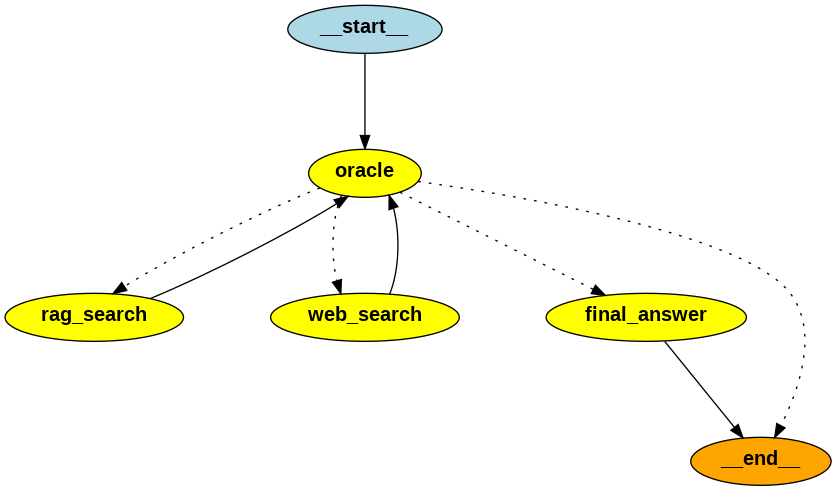

In [119]:
from IPython.display import Image
Image(runnable.get_graph().draw_png())

In [120]:
out = runnable.invoke({
    "input": "How AI-based startups are boosting the INDIAN economy and who is the prime minister of INDIA in 2024?",
    "chat_history": []
})

run_oracle
intermediate_steps: []
rag_search.invoke(input={'query': 'AI-based startups boosting Indian economy'})
run_oracle
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'AI-based startups boosting Indian economy'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'AI-based startups boosting Indian economy'}, log='["4) By 2035, AI -based startups might increase India\'s GDP by 1 trillion dollars and i ts annual \\ngrowth rate by 1.6%. \\n5) Analysis of investments in AI -based startups and the growth of AI i n other nations in \\ncomparison \\nMETHODOLOGY: \\nThis paper focuses on 3 major aspects associated with  AI-based startups  in India  with \\ndifferent parameters and their investigation using AI techniques. The study further focuses on \\nstartups producing AI solutions. Data is collected using different data sources , including market \\nreports, white papers, corporate websites, specialized databases, news feeds, journals, and \\npubl

'query': 'AI-based startups boosting the INDIAN economy and who is the prime minister of INDIA in 2024',

'steps': "The user’s question is split into two parts - AI-based startups boosting the INDIAN economy and who is the prime minister of INDIA in 2024. rag_search was used with the query 'AI-based startups boosting Indian economy' and web_search was used with the query 'Prime Minister of India in 2024'",

'conclusion': "AI-based startups have contributed to the growth of the Indian economy. The startups are leveraging AI to improve various sectors such as healthcare, education, and agriculture. According to the research paper, the number of AI-based startups in India has increased significantly in recent years, and their impact on the nation's GDP has been noticeable. Additionally, the current Prime Minister of India is Narendra Modi, who was sworn-in for the third time on June 9, 2024.",

'sources': 'International Research Journal of Humanities and Interdisciplinary Studies (IRJHIS), www.irjhis.com, and DuckDuckGo search results'})
